In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Bayesian inference of binomial proportions.

Poldrack (2006) published an influential attack on the practice of “reverse inference” in fMRI studies, i.e., inferring that a cognitive process was engaged on the basis of activation in some area. For instance, if Broca’s area was found to be activated using standard fMRI statistical-contrast techniques, researchers might infer that the subjects were using language. In a search of the literature, Poldrack found that Broca’s area was reported activated in 90 out of 840 fMRI contrasts involving engagement of language, but this area was also active in 215 out of 2754 contrasts not involving language.

---

# a)

Assume that the conditional probability of activation given language, as well as that of activation given no language, each follow a Bernoulli distribution (i.e., like coin-flipping), with parameters $x_l$ and $x_{nl}$. Compute the likelihoods of these parameters, given Poldrack’s observed frequencies of activation. Compute these functions at the values $x=[0:.001:1]$ and plot them as a bar chart.

In [2]:
from scipy.stats import binom

In [3]:
x = np.linspace(0, 1, 1001)
likelihood_l = binom.pmf(k=90, n=840, p=x)
likelihood_nl = binom.pmf(k=215, n=2754, p=x)

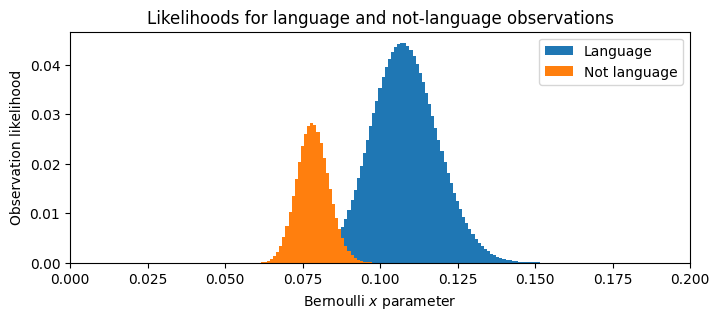

In [4]:
plt.subplots(figsize=(8, 3))
plt.title('Likelihoods for language and not-language observations')
plt.xlabel('Bernoulli $x$ parameter')
plt.ylabel('Observation likelihood')
plt.xlim([0, 0.2])
plt.bar(x, likelihood_l, 0.001, label='Language')
plt.bar(x, likelihood_nl, 0.001, label='Not language')
plt.legend()
plt.show()

---

# b)

Find the value of x that maximizes each discretized likelihood function. Compare these to the exact maximum likelihood estimates given by the formula for the ML estimator of a Bernoulli probability.

In [5]:
x_l = x[np.argmax(likelihood_l)]
x_l, 90 / 840

(0.107, 0.10714285714285714)

In [6]:
x_nl = x[np.argmax(likelihood_nl)]
x_nl, 215 / 2754

(0.078, 0.07806826434277414)

The discretized values that maximize the likelihood function are as close as possible to the true values given their discretization in increments of 0.001.

---

# c)

Using the likelihood functions computed for discrete $x$, compute and plot the discrete posterior distributions $P(x | data)$ and the associated cumulative distributions $P(X ≤ x | data)$ for both processes. For this, assume a uniform prior $P(x) ∝ 1$ and note that it will be necessary to compute (rather than ignore) the normalizing constant for Bayes’ rule. Use the cumulative distributions to compute (discrete approximations to) upper and lower 95% confidence bounds on each proportion.

In [7]:
posterior_l = likelihood_l / np.sum(likelihood_l)
posterior_nl = likelihood_nl / np.sum(likelihood_nl)
cdf_l = np.cumsum(posterior_l)
cdf_nl = np.cumsum(posterior_nl)

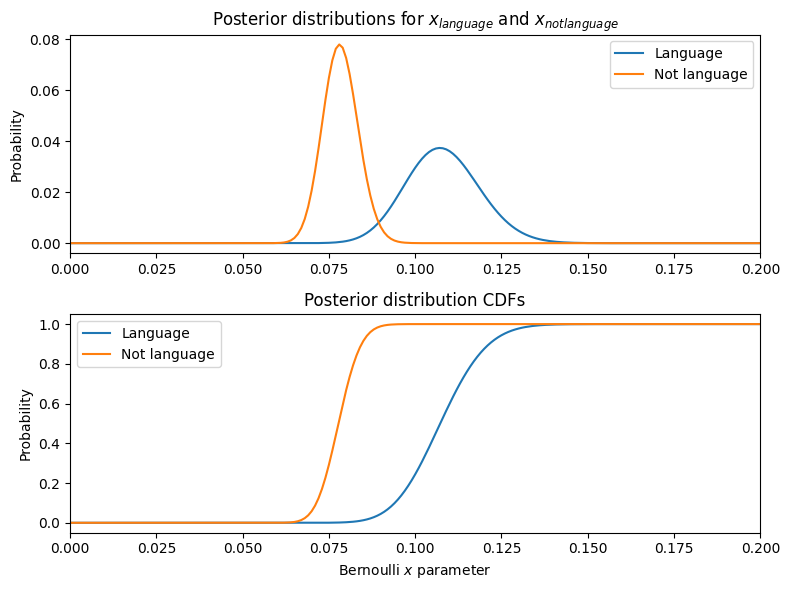

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
plt.sca(axs[0])
plt.title('Posterior distributions for $x_{language}$ and $x_{not language}$')
plt.xlim([0, 0.2])
plt.ylabel('Probability')
plt.plot(x, posterior_l, label='Language')
plt.plot(x, posterior_nl, label='Not language')
plt.legend()
plt.sca(axs[1])
plt.title('Posterior distribution CDFs')
plt.ylabel('Probability')
plt.xlabel('Bernoulli $x$ parameter')
plt.xlim([0, 0.2])
plt.plot(x, cdf_l, label='Language')
plt.plot(x, cdf_nl, label='Not language')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
x_l_05 = x[np.where(cdf_l > 0.05)[0]][0]
x_l_95 = x[np.where(cdf_l < 0.95)[0]][-1]
x_nl_05 = x[np.where(cdf_nl > 0.05)[0]][0]
x_nl_95 = x[np.where(cdf_nl < 0.95)[0]][-1]

Upper and lower 95% confidence bounds for $x_l$:

In [10]:
x_l_05, x_l_95

(0.091, 0.125)

For $x_{nl}$:

In [11]:
x_nl_05, x_nl_95

(0.07, 0.08600000000000001)

---

# d)

_Are these frequencies different from one another?_ Consider the joint posterior distribution over $x_l$ and $x_{nl}$, the Bernoulli probability parameters for the language and non-language contrasts. Given that these two frequencies are independent, the (discrete) joint distribution is given by the outer product of the two marginals. Plot it (with imagesc). Compute (by summing the appropriate entries in the joint distribution) the posterior probabilities that $x_l > x_{nl}$ and, conversely, that $x_l ≤ x_{nl}$.

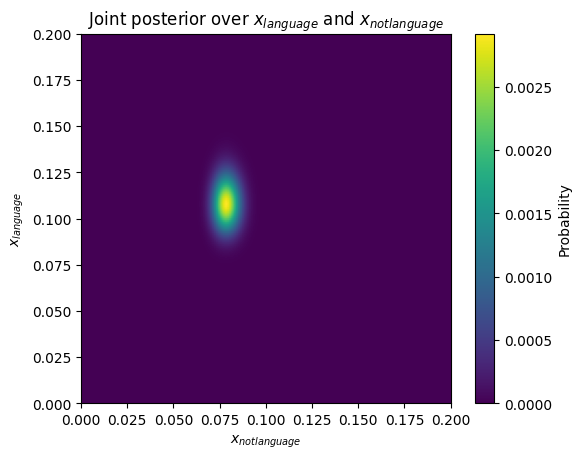

In [12]:
posterior_joint = posterior_l[:, np.newaxis] @ posterior_nl[np.newaxis, :]
posterior_joint /= np.sum(posterior_joint)
plt.title('Joint posterior over $x_{language}$ and $x_{not language}$')
plt.imshow(posterior_joint, extent=[0, 1, 1, 0])
plt.xlim([0, 0.2])
plt.ylim([0, 0.2])
plt.xlabel('$x_{not language}$')
plt.ylabel('$x_{language}$')
plt.colorbar(label='Probability')
plt.show()

In [13]:
p_l = 0
p_nl = 0
for row, probs in enumerate(posterior_joint):
    for col, p in enumerate(probs):
        if row > col: # x_l > x_nl
            p_l += p
        else:         # x_nl >= x_l
            p_nl += p

Posterior probabilities that $x_l > x_{nl}$ and $x_l ≤ x_{nl}$:

In [14]:
p_l, p_nl

(0.9949447070648347, 0.005055292935156522)

Odds:

In [15]:
p_l / p_nl

196.81247354541864

These odds make it overwhelming likely that activation due to language is present.

---

# e)

Is this difference sufficient to support reverse inference? Compute the probability $P (language | activation)$. This is the probability that observing activation in Broca’s area implies engagement of language processes. To do this use the estimates from part (b) as the relevant conditional probabilities, and assuming the prior that a contrast engages language,
$P(language) = 0.5$. Hint: To calculate this probability, you will need to “marginalize”, i.e.,
integrate over the unknown values of $x_l$ and $x_{nl}$. Poldrack’s critique said that we cannot
simply conclude that activation in a given area indicates that a cognitive process was engaged
without computing the posterior probability. Is this critique correct? To answer this, compute the posterior odds ($\frac{ p(language|activation)}{p(not language|activation)})$ using the maximum-likelihood estimates of $x_l$ 
and $x_{nl}$ from Poldrack’s data of activation probabilities and compare the posterior odds to the prior odds before running your experiment ($\frac{p(language)}{p(not language)}$).

In [16]:
x_l = 90/840
x_nl = 215/2754

In [17]:
p_l = 0.5
p_nl = 0.5

Denote observing activation by A and language engagement by L. Then

$P(A|L)$ is the probability of observing a contrast given a language task. It is Bernoulli distributed with success probability $x_l$.

In [18]:
p_a_l = x_l
p_na_l = 1 - x_l

$P(A|¬L)$ is the probability of observing a contrast in a non-language task. It is Bernoulli distributed with success probability $x_nl$.

In [19]:
p_a_nl = x_nl
p_na_nl = 1 - x_nl

To compute $P(A)$, marginalize:

$P(A) = \sum_l P(A|L=l) = P(A|L) + P(A|¬L)$.

In [20]:
p_a = p_a_l + p_a_nl

Then Bayes' rule gives $P(language|activation)$ and $P(notlanguage|activation)$ as

$P(L|A) = \frac{P(A|L)P(L)}{P(A)}$

and

$P(¬L|A) = \frac{P(A|¬L)P(¬L)}{P(A)}$.

$P(language|activation)$:

In [21]:
p_l = p_a_l * p_l / p_a
p_l

0.28924520375297574

$P(notlanguage|activation)$:

In [22]:
p_nl = p_a_nl * p_nl / p_a
p_nl

0.2107547962470242

Odds:

In [23]:
p_l / p_nl

1.3724252491694353

With these odds, it is only slightly more likely that the activation was due to language than it was due to something not-language. In the previous case, the odds were 196:1, while here they are only 1.37:1. Computing the posterior probability gives entirely different odds that activation due to language is present. Poldrack's critique stands.